In [145]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import lightgbm as lgb
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

In [146]:
df = pd.read_csv('../Real_Umbilo.csv', sep=';',decimal=',')
df.set_index('Dia', inplace=True)

df

,Q_entrada,NH_entrada,TSS_entrada,DQO_entrada,DBO_entrada,TN_entrada,TP_entrada,DQO_saida,Nitrato_saida,Amonia_saida
Dia,,,,,,,,,,
0,4719.000000,21.000000,271.000000,391.000000,198.575000,34.060000,8.020000,33.0,10.8,0.6
1,5866.458829,22.000327,276.000327,399.999347,203.059809,35.360294,8.099990,35.0,12.0,0.5
2,5358.157069,23.998870,281.996233,406.995103,206.957307,37.558734,8.149966,37.0,14.0,0.5
3,5266.313109,22.999791,278.000209,401.000418,203.710285,36.399787,8.109998,39.0,14.0,0.5
4,6671.931586,21.000432,274.999568,396.999136,201.824410,34.220441,8.060004,41.0,14.0,0.5
...,...,...,...,...,...,...,...,...,...,...
360,5120.341705,20.998558,184.998558,266.997116,135.395000,29.898501,6.929986,36.0,12.6,2.1
361,5587.915779,22.000000,182.001170,263.000000,134.093479,30.780012,6.900000,36.0,12.8,1.7
362,5984.690649,22.998229,179.999646,259.000354,131.495253,31.668215,6.869996,37.0,13.0,1.4


In [147]:
y = df['DQO_saida']
X = df.drop(['DQO_saida',
            'Nitrato_saida',
            'Amonia_saida',
            'TP_entrada',
            'DQO_entrada',
            'DBO_entrada',], axis=1)

print("X", X.shape)
print("y", y.shape)

X (365, 4)
y (365,)


In [148]:
seed = 42

# separando treino e teste
X_training, X_test, y_training, y_test = train_test_split(X, y, shuffle=False, test_size=0.082) 
print("Test set X", X_test.shape)
print("Test set y", y_test.shape)

Test set X (30, 4)
Test set y (30,)


In [149]:
# Padronização (Standardization) para o y
# Sempre usar os dados de treino apenas para construir o modelo, então transformar o teste com base no treino (como se o teste fossem dados novos)
y_train = np.array(y_training).reshape(len(y_training),1)
y_testing = np.array(y_test).reshape(len(y_test),1)

scalery = StandardScaler().fit(y_train)
normalized_y_train = pd.DataFrame(
    scalery.transform(y_train),
    columns = [y_training.name],
    index = y_training.index
)
normalized_y_train = normalized_y_train.squeeze()

normalized_y_test = pd.DataFrame(
    scalery.transform(y_testing),
    columns = [y_test.name],
    index = y_test.index
)
normalized_y_test = normalized_y_test.squeeze()


# Padronização dos previsores (DataFrame X)
scalerX = StandardScaler().fit(X_training)

normalized_x_train = pd.DataFrame(
    scalerX.transform(X_training),
    columns = X_training.columns,
    index = X_training.index
)


normalized_x_test = pd.DataFrame(
    scalerX.transform(X_test),
    columns = X_test.columns,
    index = X_test.index
)

In [150]:
# Multi-layer Perceptron regressor com validação cruzada e Grid Search

'''class sklearn.neural_network.MLPRegressor(
hidden_layer_sizes=(100,), activation='relu',*, solver='adam', alpha=0.0001, batch_size='auto',
learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True,
random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9,
beta_2=0.999, epsilon=1e-08,n_iter_no_change=10, max_fun=15000)
'''

# definindo os valores possíveis dos parâmetros a serem testados
params = {'hidden_layer_sizes': [(50,50),(100,100),(16,16,16),(50,50,50),(32,32,32,32)],
          'solver': ['adam','lbfgs','sgd'],
          'max_iter' : [500],
          'learning_rate_init' : [0.0001, 0.001, 0.01],
          'random_state' : [42],
          'tol' : [1e-5],
          'alpha':[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5] 
          }

# criando o objeto do modelo com MLPRegressor
mlp_model_cv_gs = MLPRegressor()

# criando o objeto do grid search com GridSearchCV
grid_search = GridSearchCV(mlp_model_cv_gs, param_grid=params, return_train_score=True, scoring='neg_mean_absolute_percentage_error') #,cv=10

# treinando o modelo com o grid search
grid_search.fit(normalized_x_train, normalized_y_train)

# pegando os resultados da validação cruzada (cv_results)
cv_results = pd.DataFrame(grid_search.cv_results_)

# pegando e imprimindo a melhor combinação de hiperparâmetros
cv_best_params = grid_search.best_params_
print('\n Best hyperparameters:')
print(cv_best_params)


c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the opti


 Best hyperparameters:
{'alpha': 0.5, 'hidden_layer_sizes': (16, 16, 16), 'learning_rate_init': 0.0001, 'max_iter': 500, 'random_state': 42, 'solver': 'adam', 'tol': 1e-05}


c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [151]:
# imprimindo o score médio nas bases de treino
print("Average accuracy on train set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_train_score.values[0]))

# imprimindo o score médio nas bases de validação
print("Average accuracy on validation set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_test_score.values[0]))

# configurando o modelo com a melhor combinação de hiperparâmetros
mlp_model_cv_gs.set_params(hidden_layer_sizes = cv_best_params['hidden_layer_sizes'],
                           solver = cv_best_params['solver'],
                           verbose = False
                           )

# treinando um modelo com a melhor combinação de hiperparâmetros
mlp_model_cv_gs.fit(normalized_x_train, normalized_y_train)
best_model_params = mlp_model_cv_gs.get_params()

Average accuracy on train set: -5.990 +/- 1.554
Average accuracy on validation set: -7.389 +/- 5.924


c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [153]:
# Realizando a predição no teste
y_test_pred_mlp = mlp_model_cv_gs.predict(normalized_x_test)

# Desnormalização
y_test_pred_mlp = np.array(y_test_pred_mlp).reshape(len(y_test_pred_mlp),1)
y_test_pred_mlp = scalery.inverse_transform(y_test_pred_mlp)
y_test_pred_mlp = pd.DataFrame(y_test_pred_mlp, columns=[normalized_y_test.name], index = normalized_y_test.index)
y_test_pred_mlp = y_test_pred_mlp.squeeze()

y_test_pred_mlp


# Análise dos erros das previsões
rmse_test_mlp = math.sqrt(mean_squared_error(y_test, y_test_pred_mlp))
mae_test_mlp = mean_absolute_error(y_test, y_test_pred_mlp)
mape_test_mlp = mean_absolute_percentage_error(y_test, y_test_pred_mlp)
r2_test_mlp = r2_score(y_test, y_test_pred_mlp)


df_metricas = pd.DataFrame(data={'RSME':[rmse_test_mlp], 'MAE':[mae_test_mlp], 'MAPE':[mape_test_mlp],'R²':[r2_test_mlp]})
df_metricas

,RSME,MAE,MAPE,R²
0,18.762849,14.439002,0.219447,0.405175


RSME	MAE	MAPE	R²
0	19.832129	14.376279	0.211323	0.33544

In [154]:
# Cross-validation para averiguar precisão do modelo na base de treino
print('---------Treino---------')
results = cross_val_score(mlp_model_cv_gs,X=X_training,y=y_training,cv=KFold(n_splits=10), scoring='neg_mean_absolute_percentage_error')*(-1)
print(results)
print('Média: {}\nStd: {}'.format(round(results.mean(),4),round(results.std(),4)))
print('---------Total---------')
# Predição analisada por validação cruzada para o dataset inteiro
results_total = cross_val_score(mlp_model_cv_gs,X=X,y=y,cv=KFold(n_splits=10), scoring='neg_mean_absolute_percentage_error')*(-1)
print(results_total)
print('Média: {}\nStd: {}'.format(round(results_total.mean(),4),round(results_total.std(),4)))

---------Treino---------


c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[0.42750252 0.33881924 0.17612959 0.25453106 0.55940336 0.35604189
 0.16830941 0.39034281 0.21388755 0.20924332]
Média: 0.3094
Std: 0.1208
---------Total---------


c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

[1.43801792 0.29177302 0.18219028 0.34258661 0.3680991  0.17534594
 0.32375266 0.23663995 0.2318639  0.20336299]
Média: 0.3794
Std: 0.3587


In [155]:
# Preparação do DataFrame comparativo entre a previsão e o valor real, indexado pelo dia
y_test_pred_df = pd.Series(y_test_pred_mlp,index=y_test.index)
df_comparacao = pd.concat([y_test,y_test_pred_df],axis=1)
df_comparacao.columns = ['Valor_Real','Valor_Predito']
df_comparacao['Diferenca_percentual'] = 100*(df_comparacao['Valor_Predito'] - df_comparacao['Valor_Real'])/df_comparacao['Valor_Real']
df_comparacao.sort_index(inplace=True)
df_comparacao

,Valor_Real,Valor_Predito,Diferenca_percentual
Dia,,,
335,75.0,76.052565,1.403420
336,92.0,98.797417,7.388497
337,71.0,93.726681,32.009410
338,59.0,98.565089,67.059473
339,73.0,120.285380,64.774494
340,87.0,106.727917,22.675767
341,101.0,123.441809,22.219613
342,126.0,90.771725,-27.958948
343,60.0,98.932995,64.888326


        RSME        MAE      MAPE        R²
0  18.762849  14.439002  0.219447  0.405175


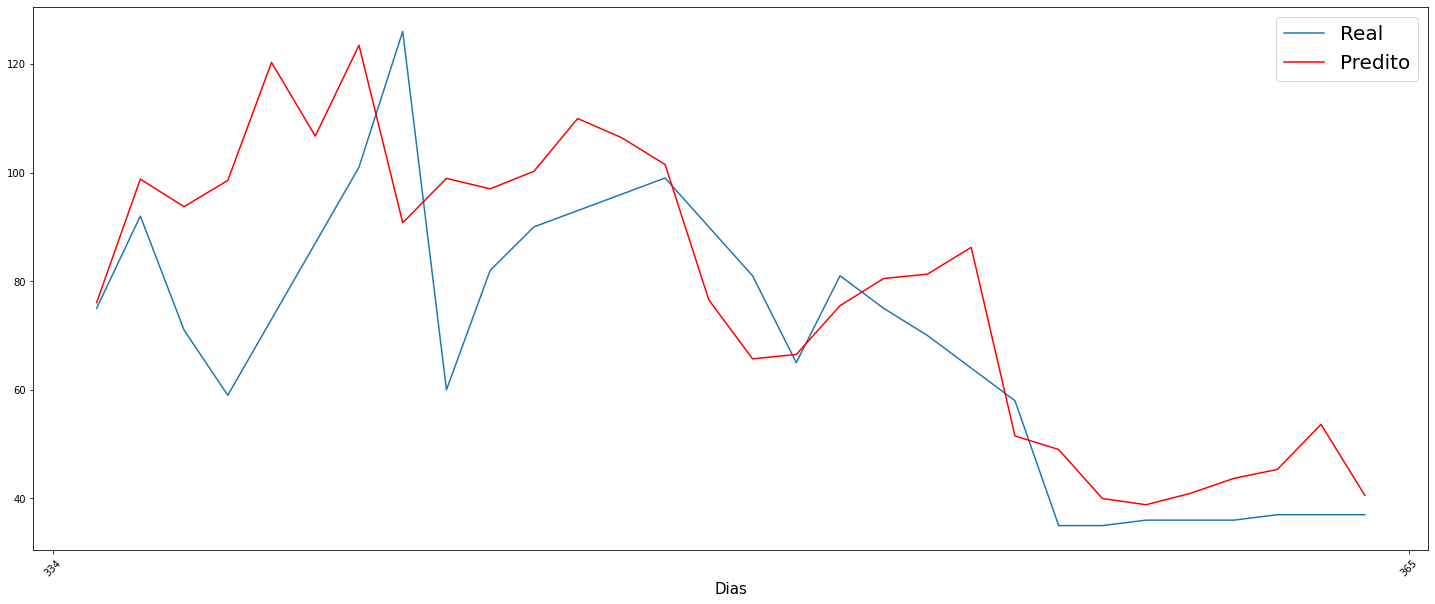

In [156]:
print(df_metricas)
import matplotlib.dates as mdates
# Visualização gráfica das predições comparadas aos valores reais
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1) 
# plt.title('', fontsize=25)
plt.plot(df_comparacao.index, df_comparacao['Valor_Real'], label = 'Real')
plt.plot(df_comparacao.index, df_comparacao['Valor_Predito'], label = 'Predito', c='r')
plt.legend(fontsize=20)
plt.xlabel('Dias', fontsize=15)
plt.xticks(fontsize=10, rotation=45)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M-%d'))

plt.show()

In [157]:
# Saving predictions

df_comparacao.to_csv("1_3-Previsoes_MLP.csv", encoding='utf-8-sig',sep=';',decimal=',')

# Previsão na base de treino

        RSME       MAE      MAPE        R²
0  33.692107  21.20851  0.232437  0.305072


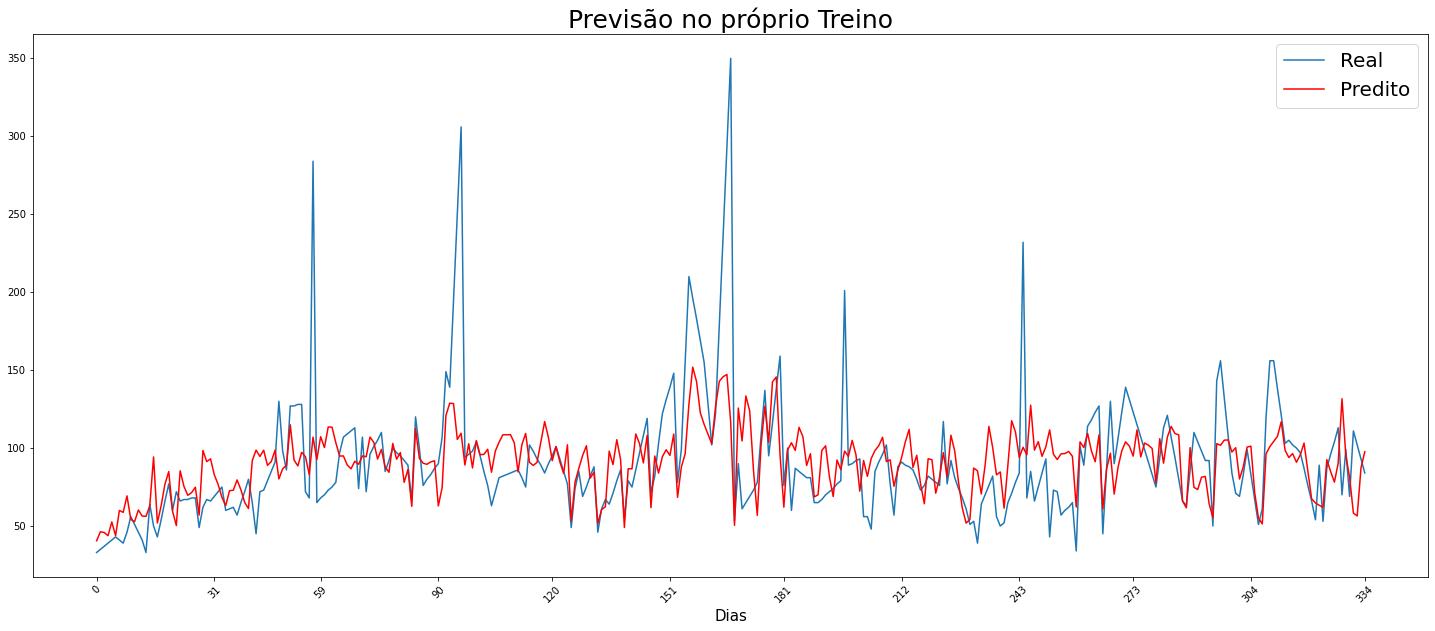

In [158]:
# Realizando a predição no traine
y_train_pred_mlp = mlp_model_cv_gs.predict(normalized_x_train)

# Desnormalização
y_train_pred_mlp = np.array(y_train_pred_mlp).reshape(len(y_train_pred_mlp),1)
y_train_pred_mlp = scalery.inverse_transform(y_train_pred_mlp)
y_train_pred_mlp = pd.DataFrame(y_train_pred_mlp, columns=[normalized_y_train.name], index = normalized_y_train.index)
y_train_pred_mlp = y_train_pred_mlp.squeeze()

y_train_pred_mlp


# Análise dos erros das previsões
rmse_train_mlp = math.sqrt(mean_squared_error(y_train, y_train_pred_mlp))
mae_train_mlp = mean_absolute_error(y_train, y_train_pred_mlp)
mape_train_mlp = mean_absolute_percentage_error(y_train, y_train_pred_mlp)
r2_train_mlp = r2_score(y_train, y_train_pred_mlp)

# Preparação do DataFrame comparativo entre a previsão e o valor real, indexado pelo dia
df_train_comparacao = pd.concat([y_training,y_train_pred_mlp],axis=1)
df_train_comparacao.columns = ['Valor_Real','Valor_Predito']
df_train_comparacao['Diferenca_percentual'] = 100*(df_train_comparacao['Valor_Predito'] - df_train_comparacao['Valor_Real'])/df_train_comparacao['Valor_Real']
df_train_comparacao.sort_index(inplace=True)
df_train_comparacao


df_train_metricas = pd.DataFrame(data={'RSME':[rmse_train_mlp], 'MAE':[mae_train_mlp], 'MAPE':[mape_train_mlp],'R²':[r2_train_mlp]})
print(df_train_metricas)

# Visualização gráfica das predições comparadas aos valores reais
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1) 
plt.title('Previsão no próprio Treino', fontsize=25)
plt.plot(df_train_comparacao.index, df_train_comparacao['Valor_Real'], label = 'Real')
plt.plot(df_train_comparacao.index, df_train_comparacao['Valor_Predito'], label = 'Predito', c='r')
plt.legend(fontsize=20)
plt.xlabel('Dias', fontsize=15)
plt.xticks(fontsize=10, rotation=45)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M-%d'))

plt.show()

In [159]:
# Gráfico de cima, queremos os dados só para o melhor modelo (base de treino)
df_train_comparacao.to_csv('2_3-Previsoes_TREINO_MLP.csv',sep=';',decimal=',',encoding='utf-8-sig')

# PDPs and Permutation Importance

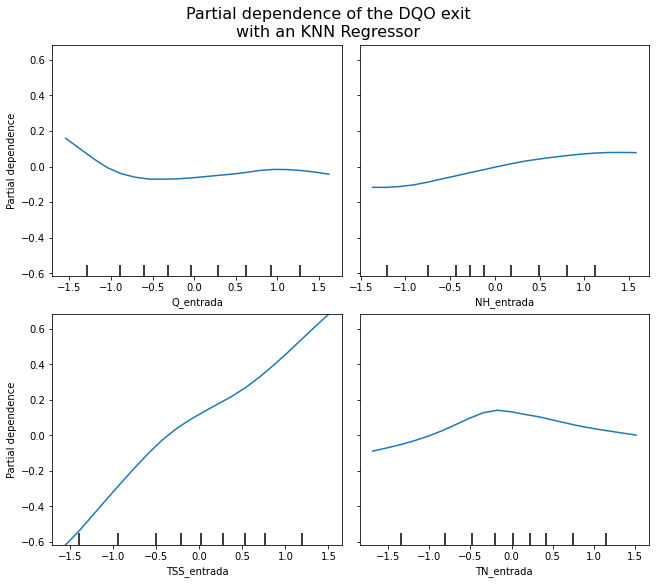

In [160]:
from sklearn.inspection import PartialDependenceDisplay

common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

# print("Computing partial dependence plots...")
features_info = {
    # features of interest
    "features": X_training.columns,
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    # "categorical_features": categorical_features,
}

_, ax = plt.subplots(ncols=2, nrows=2, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    mlp_model_cv_gs,
    normalized_x_train,
    **features_info,
    ax=ax,
    **common_params,
)

_ = display.figure_.suptitle(
    "Partial dependence of the DQO exit\n"
    "with an KNN Regressor",
    fontsize=16,
)

,Importance_mean,Importance_std,Importance_mean_normalized
TSS_entrada,0.436967,0.055156,0.502153
Q_entrada,0.178670,0.028046,0.205323
TN_entrada,0.145383,0.018856,0.167071
NH_entrada,0.109167,0.019410,0.125453


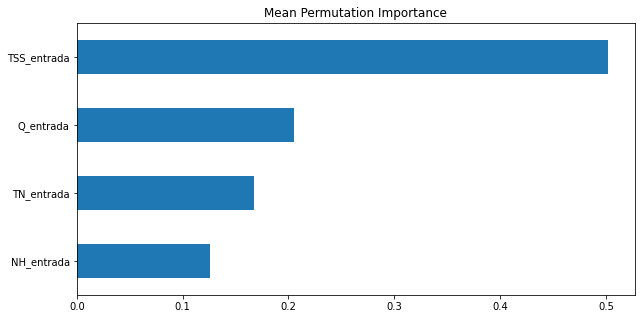

In [161]:
from sklearn.inspection import permutation_importance
r = permutation_importance(mlp_model_cv_gs, normalized_x_train, normalized_y_train,
                           n_repeats=30,
                           random_state=0)
# r.importances_mean
# r.importances_std

df_permutation_importance = pd.DataFrame(
    data={'Importance_mean': r.importances_mean,
          'Importance_std': r.importances_std},
    index=normalized_x_train.columns
)

df_permutation_importance['Importance_mean_normalized'] = df_permutation_importance['Importance_mean']/df_permutation_importance['Importance_mean'].sum()

df_permutation_importance = df_permutation_importance.sort_values('Importance_mean',ascending=False)

df_permutation_importance['Importance_mean_normalized'].sort_values(ascending=True).plot.barh(figsize=(10,5), title='Mean Permutation Importance')

df_permutation_importance

In [162]:
df_permutation_importance.to_csv('3_3-Permutation_Importance_MLP.csv',sep=';',decimal=',',encoding='utf-8-sig')

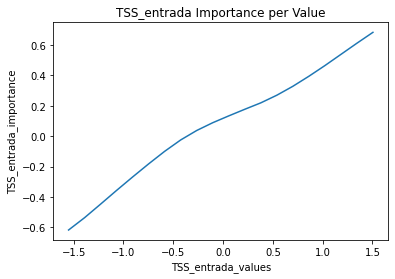

,DBO_entrada_importance,Q_entrada_importance,Q_entrada_values,NH_entrada_importance,NH_entrada_values,TSS_entrada_importance,TSS_entrada_values
0,0.158993,0.158993,-1.545764,-0.117355,-1.365209,-0.616564,-1.551337
1,0.102063,0.102063,-1.379149,-0.117244,-1.210232,-0.535468,-1.390468
2,0.044667,0.044667,-1.212533,-0.112261,-1.055255,-0.446339,-1.229599
3,-0.005921,-0.005921,-1.045917,-0.102569,-0.900279,-0.356035,-1.068730
4,-0.040056,-0.040056,-0.879302,-0.087460,-0.745302,-0.267848,-0.907861
5,-0.060023,-0.060023,-0.712686,-0.069570,-0.590325,-0.181793,-0.746992
6,-0.070600,-0.070600,-0.546070,-0.052564,-0.435349,-0.099300,-0.586123
7,-0.071455,-0.071455,-0.379454,-0.035023,-0.280372,-0.024603,-0.425254
8,-0.069746,-0.069746,-0.212839,-0.018055,-0.125395,0.037541,-0.264385
9,-0.064630,-0.064630,-0.046223,-0.000641,0.029582,0.088650,-0.103516


In [163]:
dict_data = {}
df_pdp = pd.DataFrame(display.pd_results[0]['average'].flatten(),columns=[X.columns[0]+'_importance'])
for i in range(len(display.pd_results)):
    dict_data[f"{X.columns[i]}_importance"] = display.pd_results[i]['average']
    dict_data[f"{X.columns[i]}_values"]  = display.pd_results[i]['values']
    # df_pdp[f"{X.columns[i]}_importance"] = dict_data[f"{X.columns[i]}_importance"].flatten()
    df_pdp[f"{X.columns[i]}_importance"] = display.pd_results[i]['average'][0]
    df_pdp[f"{X.columns[i]}_values"] = display.pd_results[i]['values'][0]


plt.plot(df_pdp.loc[:, 'TSS_entrada_values'], df_pdp.loc[:, 'TSS_entrada_importance'])
plt.xlabel('TSS_entrada_values')
plt.ylabel('TSS_entrada_importance')
plt.title('TSS_entrada Importance per Value')
plt.show()


df_pdp.to_csv('4_3-PDPs_MLP.csv',encoding='utf-8-sig',decimal=',',sep=';')
df_pdp